<a href="https://colab.research.google.com/github/RobinLin2002/DDA2003_CUHKSZ/blob/main/Algorithm_M_M_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU.")

GPU is available.


In [ ]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

MPS not available because the current PyTorch install was not built with MPS enabled.


In [ ]:
""" M/M/1 Simulator """
def M_M_1_Simulator(arrival_rate, service_rate, num_customers):
    interarrival_times = np.random.exponential(scale=1/arrival_rate, size=num_customers)
    service_times = np.random.exponential(scale=1/service_rate, size=num_customers)
    sojourn_times = np.zeros(num_customers+1)

    for t in range(num_customers):
        sojourn_times[t+1] = np.max([sojourn_times[t] - interarrival_times[t], 0]) + service_times[t]

    sample = np.vstack([interarrival_times, service_times,sojourn_times[:-1],sojourn_times[1:]]).T
    # Each row of sample is (A_t, S_t, R_{t-1}, R_t)

    return sample

In [ ]:
""" Kernel functions """
# Gaussian Radial Basis Function (RBF) kernel implementation
def gaussian_kernel_matrix(X, sigma=1.0):
    X = X.to(device)
    distances = (X.reshape(len(X),1) - X) ** 2
    kernel_matrix = torch.exp(-distances / (2 * sigma ** 2)) - torch.eye(len(X),device = device)
    # kernel_matrix = torch.exp(-distances / (2 * sigma ** 2)) - torch.eye(len(X), device=mps_device)

    return kernel_matrix

torch_exp_density = lambda x, rate: rate * torch.exp(-rate * x)

In [ ]:
""" Neural Network """
class DensityRatioNetwork(nn.Module):
    def __init__(self):
        super(DensityRatioNetwork, self).__init__()
        # Define the layers of the network
        self.fc1 = nn.Linear(1, 1024)  # 输入层到第一个隐藏层
        self.relu = nn.ReLU()  # ReLU激活函数
        self.dropout = nn.Dropout(0.5)  # Dropout层，防止过拟合
        self.fc2 = nn.Linear(1024, 1024)  # 第一个隐藏层到第二个隐藏层
        self.fc3 = nn.Linear(1024, 1)  # 输出层
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = x.to(device)
        x = self.fc1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        x = self.relu(self.fc2(x))
        # x = self.dropout(x)
        #x = self.relu(self.fc2(x))
        # x = self.dropout(x)
        x = self.fc3(x)
        x = self.softplus(x)

        return x


In [ ]:
def loss_function(batch_data, batch_size, fA, fS, fA_tilde, fS_tilde, sigma, regularization=0.01):
    batch_data = torch.as_tensor(batch_data, dtype=torch.float32, device = device)
    # batch_data = torch.as_tensor(batch_data, dtype=torch.float32, device=mps_device)

    delta = w(batch_data[:,2:3])*fA(batch_data[:,0:1])*fS(batch_data[:,1:2])/fA_tilde(batch_data[:,0:1])/fS_tilde(batch_data[:,1:2]) - w(batch_data[:,3:4])
    kernel = gaussian_kernel_matrix(batch_data[:,3], sigma)
    batch_value = delta.T @ kernel @ delta
    batch_value = batch_value.squeeze()
    mean_value = torch.sum(w(batch_data[:,3:4]))

    loss = batch_value /batch_size/(batch_size-1)  + regularization*(mean_value/batch_size - 1)**2/2
    #loss = (mean_value/batch_size - 1)**2/2
    return loss

In [ ]:
num_customers = 100000
arrival_rate_true = 0.3
service_rate_true = 1
arrival_rate_IS = 0.9
service_rate_IS = 1
batch_size = 1024

In [ ]:
sample_true = M_M_1_Simulator(arrival_rate_true, service_rate_true, num_customers)
sample_IS = M_M_1_Simulator(arrival_rate_IS, service_rate_IS, num_customers)
sample_IS_torch = torch.as_tensor(sample_IS, dtype=torch.float32)
sample_IS_torch= sample_IS_torch.to(device)

In [ ]:
fA = lambda x: torch_exp_density(x, arrival_rate_true)
fS = lambda x: torch_exp_density(x, service_rate_true)
fA_tilde = lambda x: torch_exp_density(x, arrival_rate_IS)
fS_tilde = lambda x: torch_exp_density(x, service_rate_IS)
w = DensityRatioNetwork().to(device)

In [ ]:

sigma= torch.median(sample_IS_torch[:,3])
sigma = sigma.to(device)
#w.to(mps_device)
optimizer = Adam(w.parameters(), lr=1e-6, betas=(0.9, 0.999), eps=1e-08)

lr_step = 100000
lr_change_rate = 0.9
scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=lr_change_rate)


for epoch in range(lr_step):
    optimizer.zero_grad()
    batch_idx = np.random.randint(0, num_customers, batch_size)
    batch_data = sample_IS_torch[batch_idx,]

    loss = loss_function(batch_data, batch_size, fA, fS, fA_tilde, fS_tilde, sigma)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 2000 == 0:
        sample_IS_torch = torch.as_tensor(sample_IS, dtype=torch.float32,device = device)
        weight = w(sample_IS_torch[:,3:4]).cpu().detach().numpy().squeeze()
        result = np.sum(weight*(sample_IS[:,3] > 10))/np.sum(weight)
        print(f'Epoch {epoch}: Loss {loss.item()} result {result}')

        #for weight in w.parameters():
        #    print(torch.norm(weight))

Epoch 0: Loss -0.0025386353954672813 result 0.5602699518203735
Epoch 2000: Loss -0.02271082065999508 result 0.0758357048034668
Epoch 4000: Loss 0.0019453050335869193 result 0.05352543666958809
Epoch 6000: Loss -0.000555878272280097 result 0.04725482687354088
Epoch 8000: Loss 0.00436804536730051 result 0.03653660789132118
Epoch 10000: Loss 4.524970427155495e-05 result 0.020839987322688103
Epoch 12000: Loss 0.0009204082889482379 result 0.016479546204209328
Epoch 14000: Loss 0.0023746443912386894 result 0.010692710056900978
Epoch 16000: Loss 0.005421916954219341 result 0.010821299627423286
Epoch 18000: Loss -0.0015556375728920102 result 0.007331361062824726
Epoch 20000: Loss 0.00427201297134161 result 0.004539566580206156
Epoch 22000: Loss -0.0027014371007680893 result 0.007135913707315922
Epoch 24000: Loss 0.014526983723044395 result 0.0082466509193182
Epoch 26000: Loss 0.00030715917819179595 result 0.004927969072014093
Epoch 28000: Loss -0.022899335250258446 result 0.002525607356801629


In [ ]:
gamma = 30
print("Theoretical R > 10:", np.exp(-(service_rate_true-arrival_rate_true)*gamma))
print("Naive MC R > 10:", np.mean(sample_true[:,3] > gamma))
sample_IS_torch = torch.as_tensor(sample_IS, dtype=torch.float32,device = device)
weight = w(sample_IS_torch[:,3:4]).cpu().detach().numpy().squeeze()
print('Our result:', np.sum(weight*(sample_IS[:,3] > gamma))/np.sum(weight))

Theoretical R > 10: 7.582560427911907e-10
Naive MC R > 10: 0.0
Our result: 6.901277e-11


In [ ]:
w_true = lambda x: (service_rate_true-arrival_rate_true)*torch.exp(-(service_rate_true-arrival_rate_true)*x) \
            / ((service_rate_IS-arrival_rate_IS)*torch.exp(-(service_rate_IS-arrival_rate_IS)*x))
batch_idx = np.random.randint(0, num_customers, 512)
batch_data = sample_IS[batch_idx,]
batch_data = torch.as_tensor(batch_data, dtype=torch.float32,device = device)
print('standard w:', torch.mean(w_true(batch_data[:,3:4])))
print('calculated w:', torch.mean(w(batch_data[:,3:4])))

standard w: tensor(1.0299, device='cuda:0')
calculated w: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
delta = w_true(batch_data[:,2:3])*fA(batch_data[:,0:1])*fS(batch_data[:,1:2])/fA_tilde(batch_data[:,0:1])/fS_tilde(batch_data[:,1:2]) - w_true(batch_data[:,3:4])
kernel = gaussian_kernel_matrix(batch_data[:,3], sigma)
batch_value = delta.T @ kernel @ delta
print(batch_value/batch_size/(batch_size-1))

delta = w(batch_data[:,2:3])*fA(batch_data[:,0:1])*fS(batch_data[:,1:2])/fA_tilde(batch_data[:,0:1])/fS_tilde(batch_data[:,1:2]) - w_true(batch_data[:,3:4])
kernel = gaussian_kernel_matrix(batch_data[:,3], sigma)
batch_value = delta.T @ kernel @ delta
print(batch_value/batch_size/(batch_size-1))

tensor([[0.0013]], device='cuda:0')
tensor([[-0.0134]], device='cuda:0', grad_fn=<DivBackward0>)


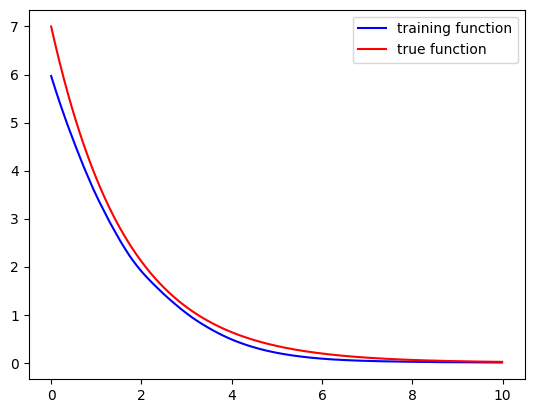

In [ ]:
x = torch.arange(0, 10, 0.01)
x = x.reshape(len(x),1)
line1, = plt.plot(x.cpu().detach().numpy(), w(x).cpu().detach().numpy(), "blue", label="training function")
line2, = plt.plot(x.cpu().detach().numpy(), w_true(x).cpu().detach().numpy(), "red", label="true function")
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_save_path = "/content/drive/MyDrive/DDA6104/AlgorithmMM1.pth"
torch.save(w.state_dict(), model_save_path)
model = DensityRatioNetwork()
model.load_state_dict(torch.load(model_save_path))